In [68]:
# LOAD LIBRARY
import pandas as pd
from supabase import create_client, Client
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [69]:
# LOAD CONNECTION TO SUPABASE
load_dotenv()
supabase_url = os.getenv("SUPABASE_URL")
supabase_key = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

In [70]:
# GET DATABASE 
response = supabase.table("feedback_ir").select("id, created_at, user, query, result1, result2").execute()
data = response.data


In [71]:
# TO DATAFRAME
df = pd.DataFrame(data)
df = df[df['result2'].notna()]
df.head()

,id,created_at,user,query,result1,result2
0,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,"[{'suraId': 36, 'verseID': 15, 'indoText': 'Me...","[{'suraId': 36, 'verseID': 15, 'indoText': 'Me..."
1,37,2025-06-09T07:34:40.721742+00:00,337,apa itu tuhan yang maha esa,"[{'suraId': 36, 'verseID': 15, 'indoText': 'Me...","[{'suraId': 36, 'verseID': 15, 'indoText': 'Me..."
2,38,2025-06-09T07:38:19.455802+00:00,337,"hukum bagi orang yang berdusta, berbohong, men...","[{'suraId': 48, 'verseID': 25, 'indoText': 'Me...","[{'suraId': 48, 'verseID': 25, 'indoText': 'Me..."
3,39,2025-06-09T08:42:56.150263+00:00,evan,apa itu jalan yang lurus,"[{'suraId': 34, 'verseID': 30, 'indoText': 'Ka...","[{'suraId': 1, 'verseID': 7, 'indoText': '(yai..."
4,40,2025-06-09T08:45:01.825874+00:00,evan,hukum aturan nikah,"[{'suraId': 3, 'verseID': 200, 'indoText': 'Wa...","[{'suraId': 23, 'verseID': 60, 'indoText': 'da..."


In [72]:
# PREPROCESSING DATA
# 1. Parsing JSON strings in result1 and result2 columns to lists
def parse_result(val):
    if isinstance(val, str):
        try:
            return json.loads(val)
        except:
            return []
    elif isinstance(val, list):
        return val
    return []

df['result1'] = df['result1'].apply(parse_result)
df['result2'] = df['result2'].apply(parse_result)

# 2. Gabungkan dua list per baris menjadi satu list of tuple agar bisa diexplode sejajar
df['paired'] = df.apply(lambda row: list(zip(row['result1'], row['result2'])), axis=1)

# 3. Explode paired (jadi per baris mewakili pasangan result1 & result2)
df_exploded = df.explode('paired').reset_index(drop=True)

# 4. Pisahkan tuple ke dua kolom
df_exploded[['r1', 'r2']] = pd.DataFrame(df_exploded['paired'].tolist(), index=df_exploded.index)
 
# 5. Normalize dict r1 dan r2 menjadi kolom
r1_df = pd.json_normalize(df_exploded['r1']).add_prefix('r1_')
r2_df = pd.json_normalize(df_exploded['r2']).add_prefix('r2_')

df_final = pd.concat([df_exploded.drop(columns=['result1', 'result2', 'paired', 'r1', 'r2']),
                      r1_df, r2_df], axis=1)

df_final.head()


,id,created_at,user,query,r1_suraId,r1_verseID,r1_indoText,r1_score,r1_is_relevan,r2_suraId,r2_verseID,r2_indoText,r2_score,r2_is_relevan
0,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,36,15,"Mereka (penduduk negeri) menjawab, “Kamu ini h...",0.825424,False,36,15,"Mereka (penduduk negeri) menjawab, “Kamu ini h...",0.825424,False
1,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,112,1,"Katakanlah (Muhammad), “Dialah Allah, Yang Mah...",0.767163,True,112,1,"Katakanlah (Muhammad), “Dialah Allah, Yang Mah...",0.767163,False
2,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,7,67,"Dia (Hud) menjawab, “Wahai kaumku! Bukan aku k...",0.716270,False,7,67,"Dia (Hud) menjawab, “Wahai kaumku! Bukan aku k...",0.716270,False
3,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,53,21,Apakah (pantas) untuk kamu yang laki-laki dan ...,0.710502,False,53,21,Apakah (pantas) untuk kamu yang laki-laki dan ...,0.710502,False
4,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,19,4,"Dia (Zakaria) berkata, “Ya Tuhanku, sungguh tu...",0.707112,False,19,4,"Dia (Zakaria) berkata, “Ya Tuhanku, sungguh tu...",0.707112,False


In [32]:
df_final.to_csv("feedback_user.csv", index=False)

In [ ]:

df_final.to_csv('hasil_pengujian.csv', index=False)

In [73]:
# Inisialisasi list hasil
results = []

# Hitung jumlah grup (jumlah query) = total baris / 15
num_queries = len(df_final) // 15

# Loop per query (setiap 15 baris)
for i in range(num_queries):
    start = i * 15
    end = start + 15
    group = df_final.iloc[start:end]

    # Total relevan ground truth (diambil dari seluruh 15 baris)
    total_r1_rel = group['r1_is_relevan'].sum()
    total_r2_rel = group['r2_is_relevan'].sum()

    # Untuk k in [5, 10, 15]
    for k in [5, 10, 15]:
        # Ambil top-k baris
        topk = group.iloc[:k]
        
        # Hitung relevan di top-k
        r1_relevant_k = topk['r1_is_relevan'].sum()
        r2_relevant_k = topk['r2_is_relevan'].sum()

        # Hitung precision dan recall
        r1_precision = r1_relevant_k / k
        r2_precision = r2_relevant_k / k

        r1_recall = r1_relevant_k / total_r1_rel if total_r1_rel > 0 else 0
        r2_recall = r2_relevant_k / total_r2_rel if total_r2_rel > 0 else 0

        # Simpan hasil
        results.append({
            'query_id': i,
            'query_text': group['query'].iloc[0],
            'k': k,
            'r1_relevant_k': r1_relevant_k,
            'total_r1_relevant': total_r1_rel,
            'r1_precision': r1_precision,
            'r1_recall': r1_recall,
            'r2_relevant_k': r2_relevant_k,
            'total_r2_relevant': total_r2_rel,
            'r2_precision': r2_precision,
            'r2_recall': r2_recall,
        })

# Buat DataFrame hasil
df_metrics = pd.DataFrame(results)
df_metrics


,query_id,query_text,k,r1_relevant_k,total_r1_relevant,r1_precision,r1_recall,r2_relevant_k,total_r2_relevant,r2_precision,r2_recall
0,0,apa itu tuhan yang maha esa,5,1,1,0.200000,1.000000,0,0,0.000000,0.000000
1,0,apa itu tuhan yang maha esa,10,1,1,0.100000,1.000000,0,0,0.000000,0.000000
2,0,apa itu tuhan yang maha esa,15,1,1,0.066667,1.000000,0,0,0.000000,0.000000
3,1,apa itu tuhan yang maha esa,5,1,1,0.200000,1.000000,1,4,0.200000,0.250000
4,1,apa itu tuhan yang maha esa,10,1,1,0.100000,1.000000,3,4,0.300000,0.750000
5,1,apa itu tuhan yang maha esa,15,1,1,0.066667,1.000000,4,4,0.266667,1.000000
6,2,"hukum bagi orang yang berdusta, berbohong, men...",5,0,1,0.000000,0.000000,0,1,0.000000,0.000000
7,2,"hukum bagi orang yang berdusta, berbohong, men...",10,0,1,0.000000,0.000000,1,1,0.100000,1.000000
8,2,"hukum bagi orang yang berdusta, berbohong, men...",15,1,1,0.066667,1.000000,1,1,0.066667,1.000000
9,3,apa itu jalan yang lurus,5,1,1,0.200000,1.000000,2,3,0.400000,0.666667


In [74]:
# Fungsi untuk menghitung F-beta score
# β = 1 untuk F1
def fbeta(p, r, beta=1.0):
    if p + r == 0:
        return 0.0
    beta_sq = beta ** 2
    return (1 + beta_sq) * p * r / (beta_sq * p + r)

# Terapkan ke df_metrics
df_metrics['r1_f1'] = df_metrics.apply(lambda row: fbeta(row['r1_precision'], row['r1_recall'], beta=1), axis=1)
df_metrics['r2_f1'] = df_metrics.apply(lambda row: fbeta(row['r2_precision'], row['r2_recall'], beta=1), axis=1)


In [75]:
query_ids_to_remove = [0, 2, 4, 6, 11]
df_metrics = df_metrics[~df_metrics['query_id'].isin(query_ids_to_remove)]
df_metrics.reset_index(drop=True, inplace=True)

In [76]:
# df_metrics['query_id'] = df_metrics.index // 3
df_metrics

,query_id,query_text,k,r1_relevant_k,total_r1_relevant,r1_precision,r1_recall,r2_relevant_k,total_r2_relevant,r2_precision,r2_recall,r1_f1,r2_f1
0,1,apa itu tuhan yang maha esa,5,1,1,0.200000,1.000000,1,4,0.200000,0.250000,0.333333,0.222222
1,1,apa itu tuhan yang maha esa,10,1,1,0.100000,1.000000,3,4,0.300000,0.750000,0.181818,0.428571
2,1,apa itu tuhan yang maha esa,15,1,1,0.066667,1.000000,4,4,0.266667,1.000000,0.125000,0.421053
3,3,apa itu jalan yang lurus,5,1,1,0.200000,1.000000,2,3,0.400000,0.666667,0.333333,0.500000
4,3,apa itu jalan yang lurus,10,1,1,0.100000,1.000000,2,3,0.200000,0.666667,0.181818,0.307692
5,3,apa itu jalan yang lurus,15,1,1,0.066667,1.000000,3,3,0.200000,1.000000,0.125000,0.333333
6,5,apa itu tuhan yang maha esa,5,1,1,0.200000,1.000000,2,6,0.400000,0.333333,0.333333,0.363636
7,5,apa itu tuhan yang maha esa,10,1,1,0.100000,1.000000,5,6,0.500000,0.833333,0.181818,0.625000
8,5,apa itu tuhan yang maha esa,15,1,1,0.066667,1.000000,6,6,0.400000,1.000000,0.125000,0.571429
9,7,Kenapa kamu tidak beriman,5,1,1,0.200000,1.000000,1,2,0.200000,0.500000,0.333333,0.285714


In [97]:
# Visualisasi Precision dan Recall per Query untuk r1 dan r2
# Ubah df_metrics menjadi format long agar mudah divisualisasikan
df_long = pd.melt(
    df_metrics,
    id_vars=['query_id', 'k'],
    value_vars=['r1_precision', 'r2_precision', 'r1_recall', 'r2_recall', 'r1_f1', 'r2_f1'],
    var_name='metric_model',
    value_name='score'
)
# Pisahkan metric_model menjadi dua kolom: metric (precision/recall) dan model (r1/r2)
df_long['metric'] = df_long['metric_model'].apply(lambda x: x.split('_')[1])
df_long['model'] = df_long['metric_model'].apply(lambda x: x.split('_')[0])

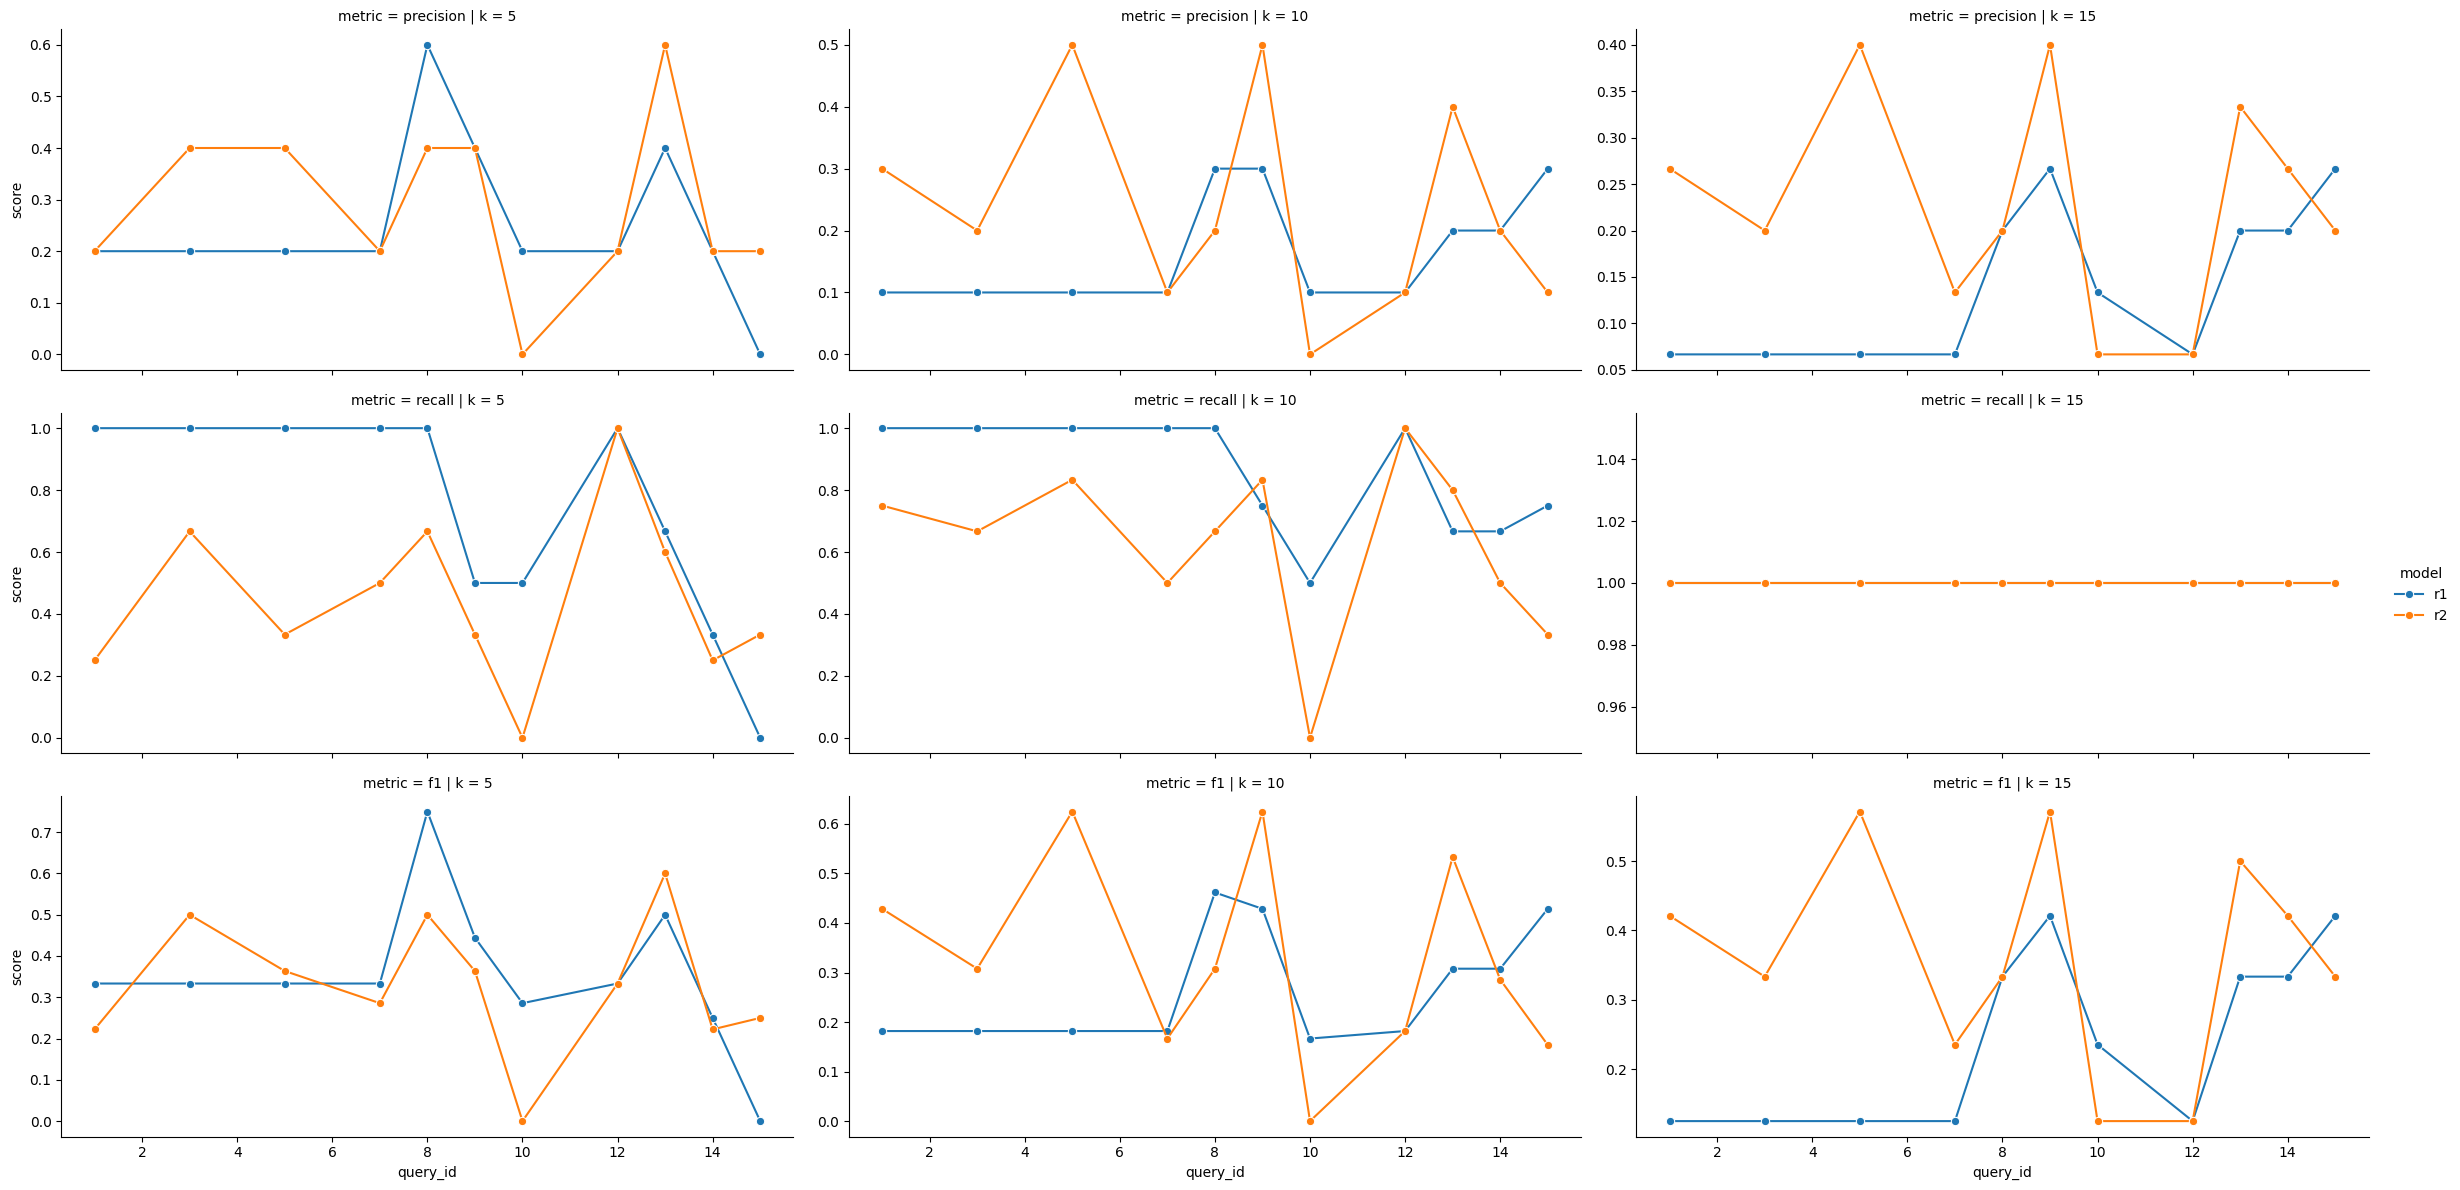

In [98]:
# Plot
g = sns.FacetGrid(df_long, row="metric", col="k", hue="model", height=4, aspect=2, sharey=False)
g.map(sns.lineplot, "query_id", "score", marker="o")
g.add_legend()

# Tambahkan judul global
# plt.subplots_adjust(top=0.9)
# g.fig.suptitle("Precision, Recall, F1-Score per Query for r1 and r2 (by k)")

plt.show()

In [99]:
df_long

,query_id,k,metric_model,score,metric,model
0,1,5,r1_precision,0.200000,precision,r1
1,1,10,r1_precision,0.100000,precision,r1
2,1,15,r1_precision,0.066667,precision,r1
3,3,5,r1_precision,0.200000,precision,r1
4,3,10,r1_precision,0.100000,precision,r1
...,...,...,...,...,...,...
193,14,10,r2_f1,0.285714,f1,r2
194,14,15,r2_f1,0.421053,f1,r2
195,15,5,r2_f1,0.250000,f1,r2
196,15,10,r2_f1,0.153846,f1,r2


In [130]:
# Visualisasi per kueri
def plot_per_query(value_vars, suptitle):
    df_long = pd.melt(
        df_metrics,
        id_vars=['query_id', 'k'],
        value_vars=value_vars,
        var_name='metric_model',
        value_name='score'
    )
    # Pisahkan metric_model menjadi dua kolom: metric (precision/recall) dan model (r1/r2)
    df_long['metric'] = df_long['metric_model'].apply(lambda x: x.split('_')[1])
    df_long['model'] = df_long['metric_model'].apply(lambda x: x.split('_')[0])
    # Plot
    g = sns.FacetGrid(df_long, row="metric", col="k", hue="model", height=4, aspect=2, sharey=False)
    g.map(sns.lineplot, "query_id", "score", marker="o")
    g.add_legend()

    # Tambahkan judul global
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle(suptitle)

    plt.show()
    

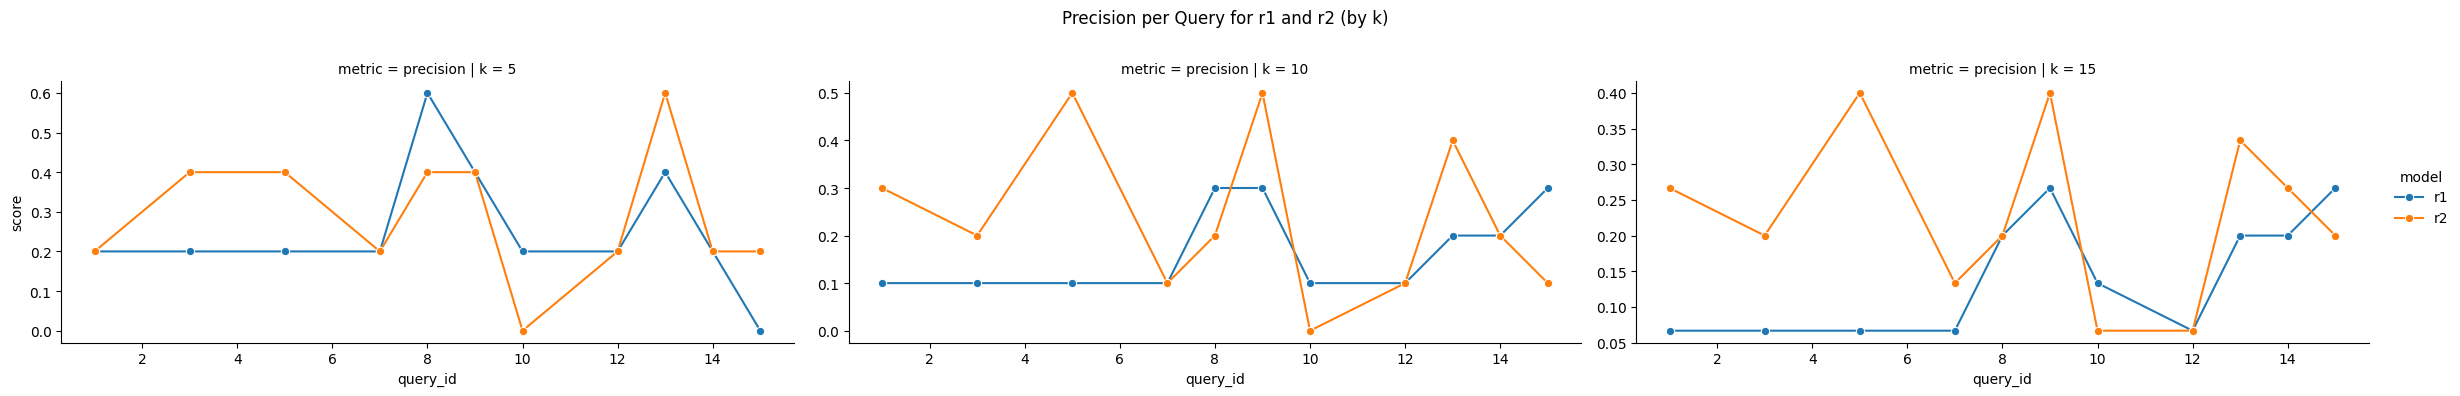

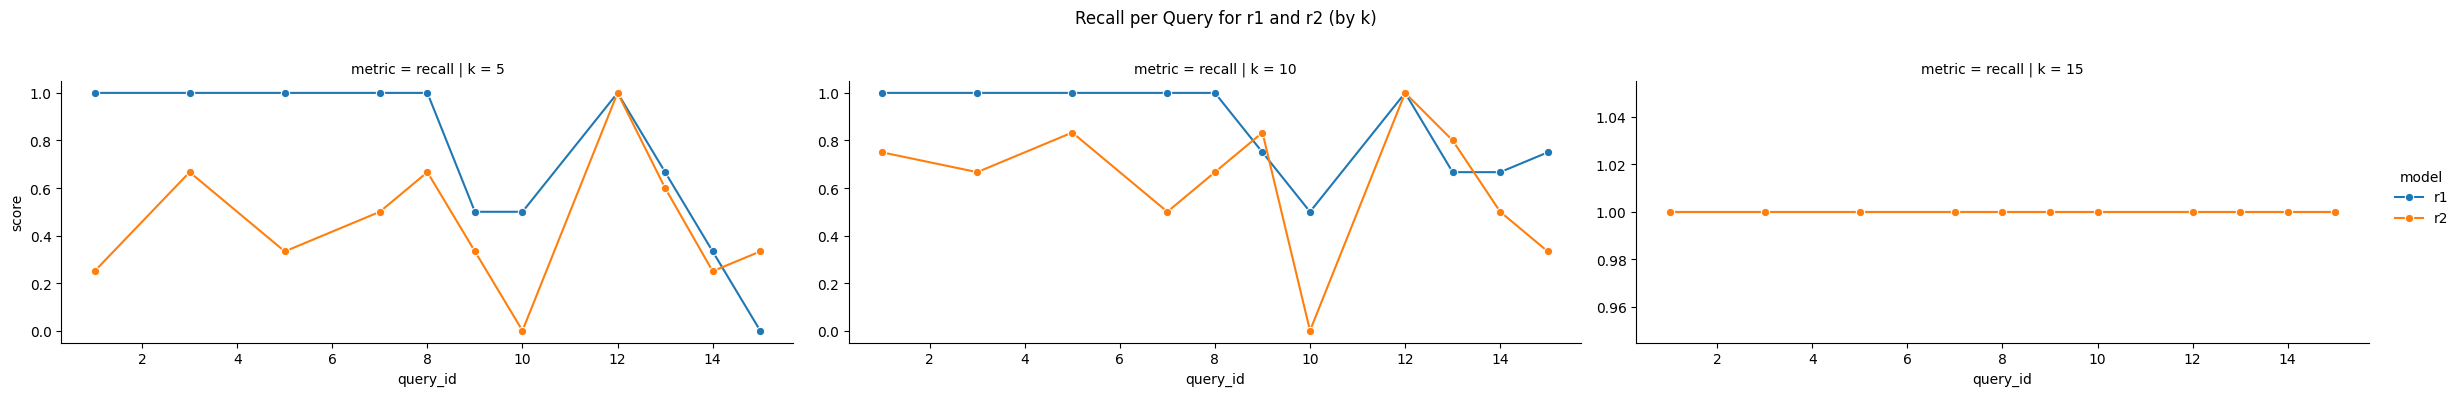

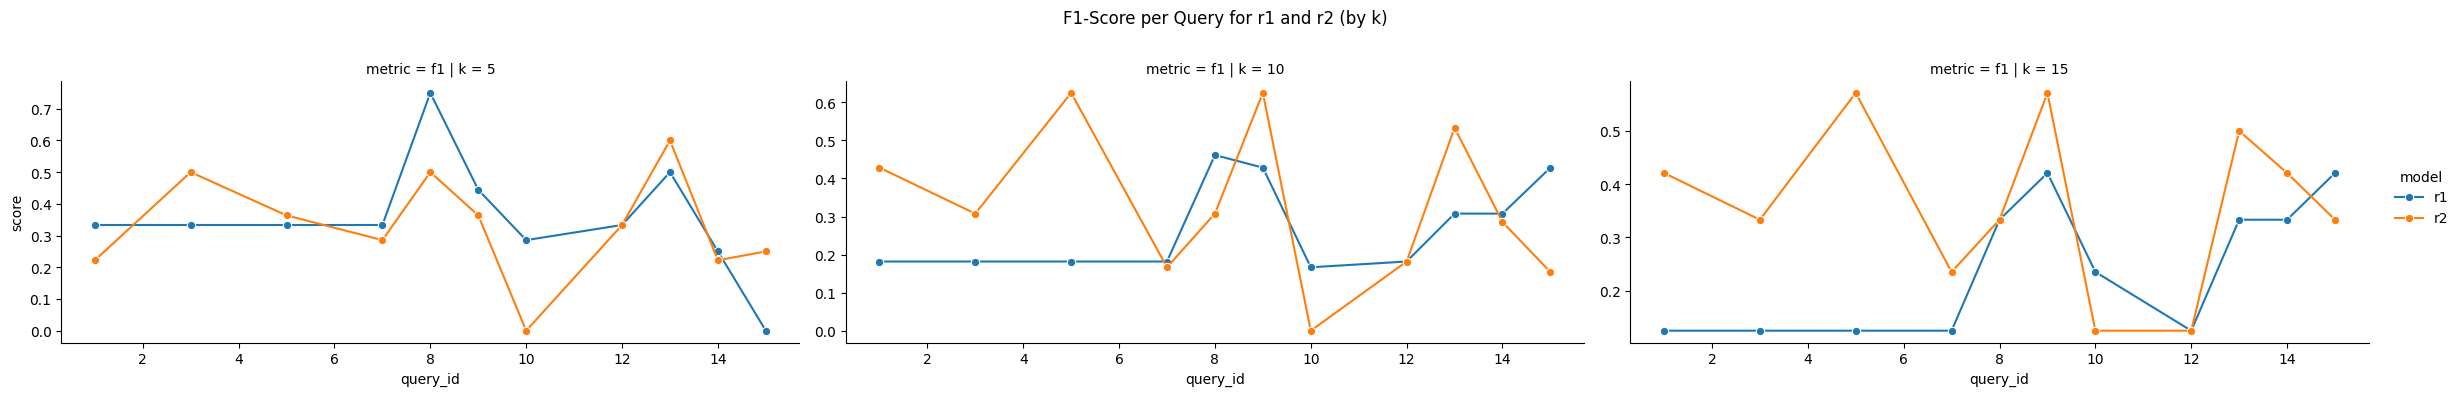

In [132]:
plot_per_query(['r1_precision', 'r2_precision'], suptitle="Precision per Query for r1 and r2 (by k)")
plot_per_query(['r1_recall', 'r2_recall'], suptitle="Recall per Query for r1 and r2 (by k)")
plot_per_query(['r1_f1', 'r2_f1'], suptitle="F1-Score per Query for r1 and r2 (by k)")

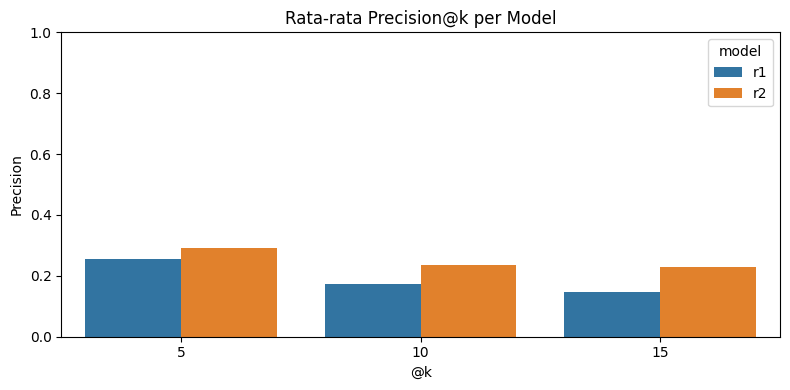

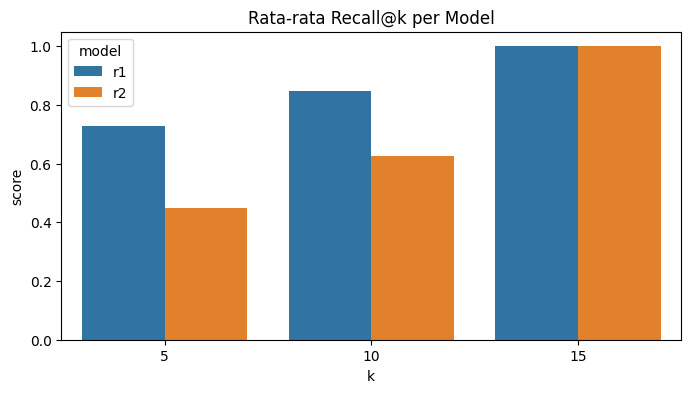

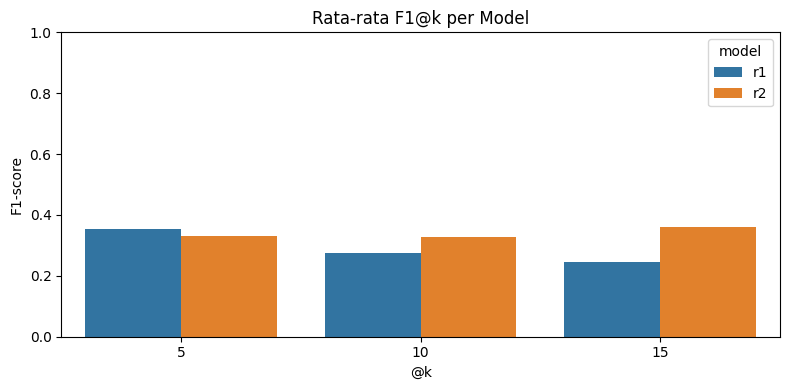

In [133]:
# Visualisasi Rata-rata Precision dan Recall per Model (r1 dan r2)
# Ringkas rata-rata precision dan recall per model untuk setiap k
summary_df = df_metrics.groupby('k').agg({
    'r1_precision': 'mean',
    'r2_precision': 'mean',
    'r1_recall': 'mean',
    'r2_recall': 'mean',
    'r1_f1': 'mean',         
    'r2_f1': 'mean'
}).reset_index()

# Ubah jadi long format untuk mudah plotting
precision_long = summary_df[['k', 'r1_precision', 'r2_precision']].melt(id_vars='k', 
    var_name='model', value_name='score')
precision_long['model'] = precision_long['model'].str.replace('_precision', '')

recall_long = summary_df[['k', 'r1_recall', 'r2_recall']].melt(id_vars='k', 
    var_name='model', value_name='score')
recall_long['model'] = recall_long['model'].str.replace('_recall', '')

f1_long = summary_df[['k', 'r1_f1', 'r2_f1']].melt(id_vars='k', 
    var_name='model', value_name='score')
f1_long['model'] = f1_long['model'].str.replace('_f1', '')

# Plot Precision
plt.figure(figsize=(8, 4))
sns.barplot(data=precision_long, x='k', y='score', hue='model')
plt.title('Rata-rata Precision@k per Model')
plt.ylabel('Precision')
plt.xlabel('@k')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot Recall
plt.figure(figsize=(8, 4))
sns.barplot(data=recall_long, x='k', y='score', hue='model')
plt.title('Rata-rata Recall@k per Model')

# Plot F1
plt.figure(figsize=(8, 4))
sns.barplot(data=f1_long, x='k', y='score', hue='model')
plt.title('Rata-rata F1@k per Model')
plt.ylabel('F1-score')
plt.xlabel('@k')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

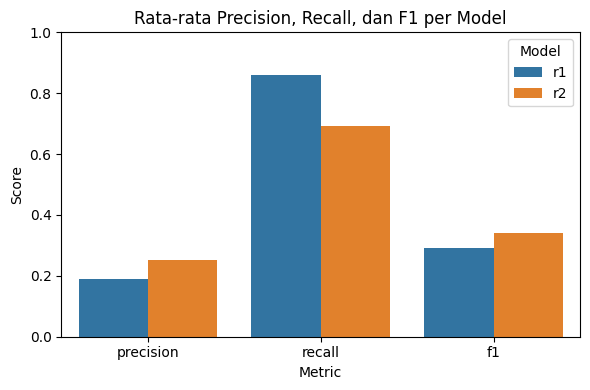

In [134]:
# Visualisasi Rata-rata Precision dan Recall per Model (r1 dan r2)

# Buat DataFrame dari hasil rata-rata (termasuk F1)
avg_df = pd.DataFrame({
    'model': ['r1', 'r2'],
    'precision': [df_metrics['r1_precision'].mean(), df_metrics['r2_precision'].mean()],
    'recall': [df_metrics['r1_recall'].mean(), df_metrics['r2_recall'].mean()],
    'f1': [df_metrics['r1_f1'].mean(), df_metrics['r2_f1'].mean()]
})

# Ubah ke format long untuk plotting
avg_df_long = pd.melt(avg_df, id_vars='model', var_name='metric', value_name='score')

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_df_long, x='metric', y='score', hue='model')
plt.title('Rata-rata Precision, Recall, dan F1 per Model')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [135]:
df_long

,query_id,k,metric_model,score,metric,model
0,1,5,r1_precision,0.200000,precision,r1
1,1,10,r1_precision,0.100000,precision,r1
2,1,15,r1_precision,0.066667,precision,r1
3,3,5,r1_precision,0.200000,precision,r1
4,3,10,r1_precision,0.100000,precision,r1
...,...,...,...,...,...,...
193,14,10,r2_f1,0.285714,f1,r2
194,14,15,r2_f1,0.421053,f1,r2
195,15,5,r2_f1,0.250000,f1,r2
196,15,10,r2_f1,0.153846,f1,r2


In [136]:
summary_df

,k,r1_precision,r2_precision,r1_recall,r2_recall,r1_f1,r2_f1
0,5,0.254545,0.290909,0.727273,0.448485,0.354257,0.330979
1,10,0.172727,0.236364,0.848485,0.625758,0.273620,0.328667
2,15,0.145455,0.230303,1.000000,1.000000,0.245673,0.360932


In [137]:
avg_df

,model,precision,recall,f1
0,r1,0.190909,0.858586,0.291183
1,r2,0.252525,0.691414,0.340193


In [138]:
# Tabel Precision
df_precision = df_metrics[['query_id', 'k', 'r1_precision', 'r2_precision']].copy()

# Tabel Recall
df_recall = df_metrics[['query_id', 'k', 'r1_recall', 'r2_recall']].copy()

# Tabel F1-score
df_f1 = df_metrics[['query_id', 'k', 'r1_f1', 'r2_f1']].copy()

# Opsional: tampilkan semua
print("Precision Table:\n", df_precision.head())
print("\nRecall Table:\n", df_recall.head())
print("\nF1 Table:\n", df_f1.head())


Precision Table:
    query_id   k  r1_precision  r2_precision
0         1   5      0.200000      0.200000
1         1  10      0.100000      0.300000
2         1  15      0.066667      0.266667
3         3   5      0.200000      0.400000
4         3  10      0.100000      0.200000

Recall Table:
    query_id   k  r1_recall  r2_recall
0         1   5        1.0   0.250000
1         1  10        1.0   0.750000
2         1  15        1.0   1.000000
3         3   5        1.0   0.666667
4         3  10        1.0   0.666667

F1 Table:
    query_id   k     r1_f1     r2_f1
0         1   5  0.333333  0.222222
1         1  10  0.181818  0.428571
2         1  15  0.125000  0.421053
3         3   5  0.333333  0.500000
4         3  10  0.181818  0.307692


In [139]:
# Filter precision dan pivot
precision_pivot = df_metrics.pivot_table(
    index='query_id',
    columns='k',
    values=['r1_precision', 'r2_precision']
)

# Rapikan nama kolom
precision_pivot.columns = [f"{model}@{k}" for model, k in precision_pivot.columns]
precision_pivot = precision_pivot.reset_index()

# Opsional: tambahkan kueri jika kamu punya kolom query
precision_pivot = precision_pivot.merge(df_metrics[['query_id']].drop_duplicates(), on='query_id', how='left')


In [140]:
# Filter recall dan pivot
recall_pivot = df_metrics.pivot_table(
    index='query_id',
    columns='k',
    values=['r1_recall', 'r2_recall']
)

recall_pivot.columns = [f"{model}@{k}" for model, k in recall_pivot.columns]
recall_pivot = recall_pivot.reset_index()
recall_pivot = recall_pivot.merge(df_metrics[['query_id']].drop_duplicates(), on='query_id', how='left')


In [141]:
# Filter f1 dan pivot
f1_pivot = df_metrics.pivot_table(
    index='query_id',
    columns='k',
    values=['r1_f1', 'r2_f1']
)

f1_pivot.columns = [f"{model}@{k}" for model, k in f1_pivot.columns]
f1_pivot = f1_pivot.reset_index()
f1_pivot = f1_pivot.merge(df_metrics[['query_id']].drop_duplicates(), on='query_id', how='left')



In [142]:
f1_pivot

,query_id,r1_f1@5,r1_f1@10,r1_f1@15,r2_f1@5,r2_f1@10,r2_f1@15
0,1,0.333333,0.181818,0.125000,0.222222,0.428571,0.421053
1,3,0.333333,0.181818,0.125000,0.500000,0.307692,0.333333
2,5,0.333333,0.181818,0.125000,0.363636,0.625000,0.571429
3,7,0.333333,0.181818,0.125000,0.285714,0.166667,0.235294
4,8,0.750000,0.461538,0.333333,0.500000,0.307692,0.333333
5,9,0.444444,0.428571,0.421053,0.363636,0.625000,0.571429
6,10,0.285714,0.166667,0.235294,0.000000,0.000000,0.125000
7,12,0.333333,0.181818,0.125000,0.333333,0.181818,0.125000
8,13,0.500000,0.307692,0.333333,0.600000,0.533333,0.500000
9,14,0.250000,0.307692,0.333333,0.222222,0.285714,0.421053


In [143]:
precision_pivot.to_csv("tabel_precision.csv", index=False)
recall_pivot.to_csv("tabel_recall.csv", index=False)
f1_pivot.to_csv("tabel_f1.csv", index=False)